# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.integrate import trapezoid
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

# Point 1

Write your own function to simulate the:

- short rate $r(t)$,  
- the numeraire $(\displaystyle e^{-\int_t^T r(s)\,ds})$

with a Hull–White model.

## Theta fitting function

$
  \displaystyle
    \theta(t)
    = \frac{\partial f_{M}(0,t)}{\partial T}
      + a\,f_{M}(0,t)
      + \frac{\sigma^{2}}{2a}\bigl(1 - e^{-2a t}\bigr)
  $

$\theta(t)
\;=\;
f'(0,t)
\;+\;
a\,f(0,t)
\;+\;
\frac{\sigma^2}{2a}\,\bigl(1 - e^{-2a t}\bigr),
$

$and\$

$
f(0,t)
=
-\frac{\partial}{\partial t}\ln P(0,t)
\;\Longrightarrow\;
f(0,t)=r(t) + t\,r'(t).
$

This derives from the price of a zero coupon bond computed as $P(0,t) = e^{-r(t)\,t} \Longrightarrow\ ln P(0,t)=-r(t)t$ and the exploitation of the product rules $f(t)
= -\frac{\mathrm{d}}{\mathrm{d}t}\bigl[-r(t)\,t\bigr]
= r(t) + t\,r'(t)$

In [ ]:
def theta_fit(Times,IR,alfa,sigma,T,DT):
  t_inter=np.linspace(0,T,int(T/DT)+1) #creates the time space over which we to interpolate
  rate_inter=np.interp(t_inter,Times,IR) #interpolation of all the zero rates between 0 and T
  rate_prime=np.gradient(rate_inter,t_inter) #first derivative of the rate with respect to t
  fwd=rate_inter+t_inter*rate_prime
  fwd_prime=np.gradient(fwd,t_inter)
  theta=fwd_prime+alfa*fwd+(sigma**2/(2*alfa))*(1-np.exp(-2*alfa*t_inter))
  return theta,rate_inter,fwd,fwd_prime

## Hull & White Simulation function


 $ dr_d(t) = \left( \theta(t) - a_d r_d(t) \right) dt + \sigma_d dW_d(t) ⇒
 \\r_{n+1} = r_n + \left( \theta(t_n) - a_d r_n \right) \Delta t + \sigma_d \sqrt{\Delta t} \, \xi_n.
\\\xi_n \sim \mathcal{N}(0,1) $


In [ ]:
np.random.seed(42) #for reproducibility

def H_W(theta, alfa, r0, sigma, dt, T,n_path):
  N=T/dt
  r_t=np.zeros((n_path,int(N)+1))
  r_t[:,0]=r0
  for i in range(int(N)):
    Z = np.random.normal(0,1,n_path)
    r_t[:,i+1]=r_t[:,i]+(theta[i]-alfa*r_t[:,i])*dt+sigma*np.sqrt(dt)*Z
  return r_t

## Numeraire function

$e^{-\int_t^{t^*} r(s) \, ds}$

Since for Simpson's rule we need at least three points because it assigns 1/3 at the extremes, 4/3 at even nodes, and 2/3 at odd nodes, we opted to use the trapezoid rule so that we can compute the integral without worrying about this. Useful, for example, when we want to compute the price of the ZCB with $t \rightarrow T$, but at the cost of some approximation error.


In [ ]:
def numeraire(rates,dt):
  N,T=rates.shape#shape returns the number or rows in N and columns in T
  numer=np.zeros((N,T))
  for i in range(N):
    for j in range(T):
      integral=trapezoid(rates[i, j:],dx=dt)#im using the trapezoid rule learned in numerical methods course to approximate the definite integral
      numer[i,j]=np.exp(-integral)
  return numer

# **Point 2**

Show that your implementation is consistent with the basic assumption that your model replicates today’s zero curve, i.e.

$$
  P(0,t)
  = \mathbb{E}^Q\!\biggl[e^{-\int_{0}^{t} r(s)\,ds}\biggr].
$$

You can test this using several sample zero curves and various parameters of mean‐reversion speed and volatility.  
One sample zero curve, for instance, could be:

| \(T\) (y)          | 1/12 | 0.5 | 1    | 3   | 5   | 10  |
|--------------------|:----:|:---:|:----:|:---:|:---:|:---:|
| Zero rate (\%)     | 0.25 | 0.60| 0.95 | 1.50| 2.10| 2.50|

## Setting up the ZCB curve

In [ ]:
Times=np.array([1/12,0.5,1,3,5,10])
IR=np.array([0.0025,0.006,0.0095,0.015,0.021,0.025])

## Find optimal parameters

In [ ]:
n_path=100 # Number of paths to simulate
dt=1/252
r0 = IR[0] # Initial short rate

# Define the objective function to minimize the absolute error
def obj_fct(params, Times, rates, r0, dt, T, n_path):
    [alpha, sigma] = params
    thetas, _, _, _ = theta_fit(Times, rates, alpha, sigma, T, dt)
    rates_sim = H_W(thetas, alpha, r0, sigma, dt, T, n_path)
    PMC = np.zeros(len(Times))
    rates_mkt = np.zeros(len(Times))
    PMKT = np.zeros(len(Times))

    for t in range(len(Times)):
        PMC[t] = np.exp(-np.mean(rates_sim[:,np.searchsorted(Times, t, 'left')] * t))
        rates_mkt[t] = IR[np.searchsorted(Times, t, 'left')]
        PMKT[t] = np.exp(-rates_mkt[t] * t)
        error = np.mean((PMC[t] - PMKT[t])**2)
    return error

# Initial guess for alpha and sigma
initial_guess = [0.05, 0.03]

# Bounds for alpha and sigma
bounds = [(0.001, 0.1), (0.001, 0.1)]

# Minimize the objective function
result = minimize(obj_fct, initial_guess, args=(Times, IR, r0, dt, Times[-1], n_path), bounds=bounds)

# Optimal parameters
optimal_alpha, optimal_sigma = result.x
print(f"Optimal alpha: {optimal_alpha}")
print(f"Optimal sigma: {optimal_sigma}")

Optimal alpha: 0.04999989236680467
Optimal sigma: 0.02999993629872113


## Error measuring

In [ ]:
MC_res=[]
PMC = np.zeros(len(Times))
rates_mkt = np.zeros(len(Times))
PMKT = np.zeros(len(Times))
thetas,_,_,_=theta_fit(Times,IR,optimal_alpha,optimal_sigma,Times[-1],dt)
rates_sim=H_W(thetas,optimal_alpha,r0,optimal_sigma,dt,Times[-1],n_path)

for t in range(len(Times)):
  PMC[t]=np.exp(-(np.mean(rates_sim[:,np.searchsorted(Times, t, 'left')]) * t))
  rates_mkt[t]=IR[np.searchsorted(Times, t, 'left')]
  PMKT[t]=np.exp(-rates_mkt[t]*t)

  MC_res.append({ 'T (y)'   : t,
        'Martek Price'   : PMKT[t],
        'Montecarlo Price'    : PMC[t],
        'Error'   : (PMC[t]-PMKT[t])**2,
    })
df_MC = pd.DataFrame(MC_res)
df_MC

T (y)  Martek Price  Montecarlo Price     Error
0      0      1.000000          1.000000  0.000000
1      1      0.990545          0.997096  0.000043
2      2      0.970446          0.993706  0.000541
3      3      0.955997          0.990574  0.001196
4      4      0.919431          0.987188  0.004591
5      5      0.900325          0.984011  0.007003

In [ ]:
np.mean(df_MC['Error']) #mean error

np.float64(0.002228987102604215)

## Plot Numeraire

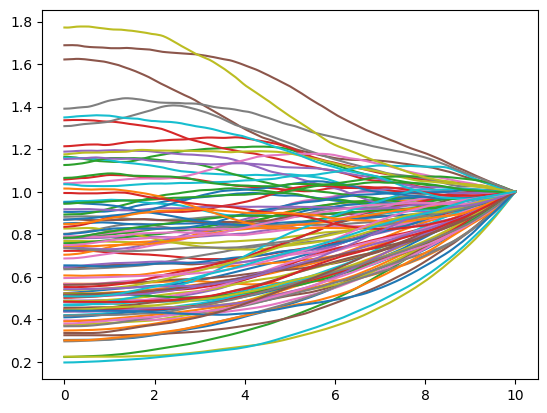

In [ ]:
Numeraire=pd.DataFrame(numeraire(rates_sim,dt))
Numeraire
for i in range(n_path):
  plt.plot(np.linspace(0,10,int(10/dt)+1), Numeraire.iloc[i,:])

plt.show()

# **Point 3**

Write your own pricing function for an interest rate swap. Suppose you are under a single
curve framework, i.e. your forwarding curve equals the discount curve. With the above
zero curve, please ensure that your price of an interest rate swap, with {maturity 10Y,
payment frequency every 6 months, K = the fixed rate of the fixed leg = 2.488%}, equals
zero - the swap is stroke at par (approximately zero due to potential differences due to
the chosen interpolation scheme you use for interpolating between the tenor points of the
zero curve to construct the discount and forward curves for each cashflow of your swap)

## Get Interpolated rates

In [ ]:
# Target times (every 6 months)
Times2 = np.arange(0, 10.5, 0.5) #every 6 months
Times2 = Times2.tolist() #convert to list

# Linear interpolation of rates at each time with numpy function
interpolated_rates = np.interp(Times2, Times, IR)
interpolated_rates_df = pd.DataFrame(interpolated_rates, columns=['Interpolated Rates'])
interpolated_rates_df.set_index(pd.Index(Times2), inplace=True) #set the index to the target times
interpolated_rates_df.T

0.0    0.5     1.0       1.5      2.0       2.5    3.0   \
Interpolated Rates  0.0025  0.006  0.0095  0.010875  0.01225  0.013625  0.015   

                      3.5    4.0     4.5   ...    5.5     6.0     6.5   \
Interpolated Rates  0.0165  0.018  0.0195  ...  0.0214  0.0218  0.0222   

                      7.0    7.5     8.0     8.5     9.0     9.5    10.0  
Interpolated Rates  0.0226  0.023  0.0234  0.0238  0.0242  0.0246  0.025  

[1 rows x 21 columns]

## Get IRS discount factors

In [ ]:
discount_factors = np.exp(-interpolated_rates * Times2) #compute discount factors
print(discount_factors)

[1.         0.9970045  0.99054498 0.98381983 0.97579769 0.9665111
 0.95599748 0.94388589 0.9305309  0.91598985 0.90032452 0.8889627
 0.87739324 0.86562802 0.85367903 0.84155829 0.82927786 0.81684984
 0.80428628 0.79159926 0.77880078]


## IRS Pricing

$
\begin{aligned}
&RFS(0)=N \sum_{\alpha+1}^{\beta} \tau_i K P(0, T_i) - N P(0, T_{\alpha}) + N P(0, T_{\beta})
\end{aligned}
$

In [ ]:
def price_interest_rate_swap(discount_factors, K, t, payment_dates): #t is the initial time of the swap
  dt = payment_dates[1] - payment_dates[0] #time step
  fixed_leg_PV = 0.0
  initial = np.searchsorted(payment_dates, t, side='left') #find the >= index of t in payment_dates

  for i in range(initial+1, len(payment_dates)):
      fixed_leg_PV += K * dt * discount_factors[i]

  first_discount_factor = discount_factors[initial]
  last_discount_factor = discount_factors[-1]

  # Output
  swap_price = fixed_leg_PV + last_discount_factor - first_discount_factor

  return swap_price

In [ ]:
K=0.02488 #fixed rate given
swap_price=price_interest_rate_swap(discount_factors, K, 0, Times2) #t=0
print(swap_price)

0.0015818019013185136


# **Point 4**

Use the functions to simulate short rates under the Hull–White model and to price an interest rate swap to calculate your future $MtM(t)$ distributions for 10,000 scenarios. Your Hull–White model calibration is as follows:

- $\alpha = 0.01$  
- $\sigma = 0.015$

Calculate the future $MtM(t)$ distributions for $t$ equal to the union of the fixing and coupon dates of the interest rate swap.

## Theta fitting

Start by fitting the thetas on the given original curve

In [ ]:
n_path=10000
alfa=0.01   #mean reversion speed
sigma=0.015 #short rate interest rate volatility

thetas,_,_,_=theta_fit(Times2,interpolated_rates,alfa,sigma,Times2[-1],dt)

## Get simulated rates

Get rates simulating with Hull White Model

In [ ]:
rates=pd.DataFrame(H_W(thetas,alfa,r0,sigma,dt,Times2[-1],n_path))
rates

0         1         2         3         4         5         6     \
0     0.0025  0.002378  0.002508  0.002004  0.001789  0.000970  0.001538   
1     0.0025  0.002194  0.003408  0.003461  0.002516  0.002211  0.002145   
2     0.0025  0.002153  0.003030  0.003568  0.004676  0.005679  0.006138   
3     0.0025  0.003054  0.003893  0.004521  0.003771  0.001789  0.002743   
4     0.0025  0.002339  0.002340  0.003399  0.004266  0.003588  0.002351   
...      ...       ...       ...       ...       ...       ...       ...   
9995  0.0025  0.003186  0.002882  0.004258  0.004529  0.004867  0.004056   
9996  0.0025  0.003147  0.001792  0.000651  0.000004  0.000953  0.003122   
9997  0.0025  0.002078  0.002620  0.002005  0.001042  0.001640  0.002728   
9998  0.0025  0.002088  0.001899  0.001814  0.002140  0.000975  0.001677   
9999  0.0025  0.002772  0.003274  0.003258  0.002818  0.002784  0.002128   

          7         8         9     ...      2511      2512      2513  \
0     0.001789  0.003182  0.002396  ... -0.006315 -0.005254 -0.006441   
1     0.002889  0.002725  0.002676  ...  0.164400  0.166532  0.164422   
2     0.006471  0.007320  0.006917  ... -0.021006 -0.020010 -0.020665   
3     0.004829  0.004929  0.003337  ...  0.014285  0.012651  0.010742   
4     0.001589  0.001934 -0.000368  ...  0.120940  0.119605  0.121405   
...        ...       ...       ...  ...       ...       ...       ...   
9995  0.004490  0.005342  0.004600  ...  0.014132  0.015561  0.016261   
9996  0.003641  0.003540  0.004304  ...  0.017910  0.018638  0.017084   
9997  0.002475  0.003540  0.002757  ...  0.055023  0.054830  0.054504   
9998  0.001265  0.001801  0.001681  ...  0.092945  0.093129  0.092487   
9999  0.001694  0.002904  0.002322  ... -0.016479 -0.016849 -0.017644   

          2514      2515      2516      2517      2518      2519      2520  
0    -0.006238 -0.005457 -0.007109 -0.006291 -0.007159 -0.006860 -0.006938  
1     0.163721  0.163286  0.161971  0.160739  0.159487  0.158322  0.157650  
2    -0.020635 -0.019637 -0.018422 -0.018921 -0.019625 -0.018981 -0.018889  
3     0.010459  0.010200  0.010641  0.010680  0.009312  0.009219  0.008749  
4     0.120731  0.121092  0.122326  0.121992  0.121294  0.119861  0.120699  
...        ...       ...       ...       ...       ...       ...       ...  
9995  0.015391  0.014885  0.015140  0.015265  0.015219  0.014740  0.015076  
9996  0.017510  0.017573  0.016763  0.015975  0.014510  0.014171  0.014924  
9997  0.053414  0.053835  0.054481  0.054723  0.054934  0.056173  0.058344  
9998  0.092450  0.092788  0.092157  0.092162  0.092808  0.093068  0.094349  
9999 -0.017416 -0.019146 -0.017708 -0.017511 -0.016022 -0.017023 -0.017177  

[10000 rows x 2521 columns]

## Get 6m simulated rates

Get daily dates

In [ ]:
daily_dates = np.zeros(len(Times2))

for i in range(len(Times2)):
    daily_dates[i] = i * 126

daily_dates

array([   0.,  126.,  252.,  378.,  504.,  630.,  756.,  882., 1008.,
       1134., 1260., 1386., 1512., 1638., 1764., 1890., 2016., 2142.,
       2268., 2394., 2520.])

Get 6m simulated rates

In [ ]:
rates_6m = rates.iloc[:, daily_dates.astype(int)]
rates_6m.columns = Times2
rates_6m

0.0       0.5       1.0       1.5       2.0       2.5       3.0   \
0     0.0025 -0.009528  0.001027 -0.018152 -0.010649  0.003311 -0.001865   
1     0.0025  0.022164  0.027918  0.031805  0.024803  0.030445  0.050108   
2     0.0025  0.004225  0.012910  0.028792  0.030936  0.038603  0.015161   
3     0.0025  0.012838  0.012938 -0.002604  0.000018 -0.007757  0.015284   
4     0.0025  0.011815  0.025430  0.017392  0.019187  0.029028  0.024986   
...      ...       ...       ...       ...       ...       ...       ...   
9995  0.0025  0.024833  0.041017  0.048995  0.045992  0.046448  0.048069   
9996  0.0025 -0.003836 -0.017973 -0.034629 -0.046115 -0.054698 -0.056325   
9997  0.0025  0.008738  0.006625  0.019266  0.019623  0.025769  0.037699   
9998  0.0025  0.018295  0.039655  0.025912  0.015027  0.028948  0.029216   
9999  0.0025  0.012879 -0.012889 -0.016710 -0.001843 -0.000610 -0.003623   

          3.5       4.0       4.5   ...      5.5       6.0       6.5   \
0    -0.002828 -0.016570  0.012225  ...  0.013196 -0.001757 -0.001874   
1     0.067137  0.075992  0.091944  ...  0.095530  0.108923  0.114817   
2     0.027512  0.037019  0.027255  ...  0.022918  0.011963  0.006175   
3     0.022331  0.031069  0.009713  ... -0.001992  0.015489  0.012520   
4     0.021305  0.024124  0.016231  ...  0.041988  0.066151  0.072685   
...        ...       ...       ...  ...       ...       ...       ...   
9995  0.056788  0.056082  0.044845  ...  0.024382  0.021725  0.009571   
9996 -0.053815 -0.048370 -0.061222  ... -0.048882 -0.052900 -0.048180   
9997  0.054768  0.057896  0.059386  ...  0.058898  0.068119  0.066882   
9998  0.040800  0.038363  0.054864  ...  0.065823  0.053726  0.050280   
9999 -0.012549 -0.013388 -0.021827  ... -0.027968 -0.031158 -0.014075   

          7.0       7.5       8.0       8.5       9.0       9.5       10.0  
0     0.001731  0.014133  0.004209 -0.006021 -0.023964 -0.017515 -0.006938  
1     0.140837  0.151054  0.141613  0.145737  0.155383  0.160203  0.157650  
2     0.005931 -0.003833 -0.012277 -0.013279 -0.023389 -0.032799 -0.018889  
3     0.017320  0.012425  0.009713 -0.002440  0.016282  0.017832  0.008749  
4     0.094364  0.093998  0.104963  0.111679  0.112245  0.121232  0.120699  
...        ...       ...       ...       ...       ...       ...       ...  
9995  0.030930  0.033146  0.034146  0.040500  0.033235  0.016199  0.015076  
9996 -0.034947 -0.015291 -0.016917 -0.003757 -0.004359  0.006489  0.014924  
9997  0.070877  0.064903  0.056984  0.056887  0.048768  0.055638  0.058344  
9998  0.043722  0.067686  0.079762  0.081929  0.076936  0.075037  0.094349  
9999 -0.016123 -0.008573 -0.008715 -0.012838 -0.014395 -0.016360 -0.017177  

[10000 rows x 21 columns]

### Plot 6m simulated rates

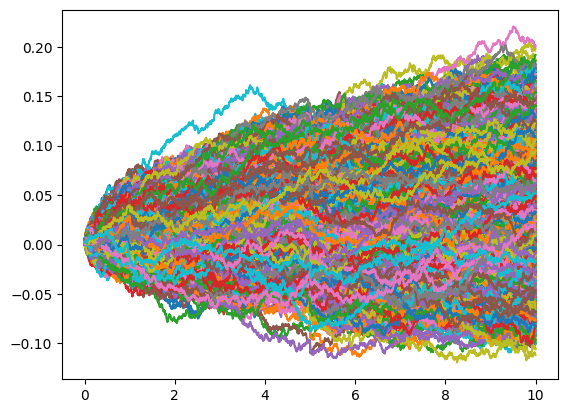

In [ ]:
T= Times2[-1]  # Last time in the series

for i in range(n_path):
    plt.plot(np.linspace(0,T,int(T/dt)+1) ,rates.iloc[i,:])
plt.show()

## Get Discount Factors

$
P(t, T) = A(t, T) \, e^{-B(t,T)\, r_d(t)}
$

**where:**

$
A(t, T) = \frac{P^M(0, T)}{P^M(0, t)} \exp \left\{ B(t, T) f^M(0, t) - \frac{\sigma^2}{4a} \left(1 - e^{-2a t} \right) B(t, T)^2 \right\}
$

$
B(t, T) = \frac{1}{a} \left( 1 - e^{-a(T - t)} \right)
$



In [ ]:
alpha = 0.01
sigma = 0.015

def discount_factors_func(alpha, sigma, rates, sim_rates, Final_T, Initial_T, Times):
    idx_Initial_T = min(np.searchsorted(Times, Initial_T, side='left'), len(rates)-1) #find the >= index of Initial_T in Times
    idx_Final_T = min(np.searchsorted(Times, Final_T, side='left'), len(rates)-1) #find the >= index of Final_T in Times
    P = 0

    fwd_mkt = rates[idx_Initial_T]+ Initial_T * np.gradient(rates, Times)[idx_Initial_T]
    disc_mkt_fin=np.exp(-rates[idx_Final_T]*Final_T) #discount factor at final time
    disc_mkt_init=np.exp(-rates[idx_Initial_T]*Initial_T) #discount factor at initial time

    P=(disc_mkt_fin/disc_mkt_init) * np.exp(1/alpha*(1-np.exp(-alpha*(Final_T-Initial_T)))*fwd_mkt-sigma**2/(4*alpha)*(1-np.exp(-2*alpha*Initial_T))*((1/alpha)*
        (1-np.exp(-alpha*(Final_T-Initial_T))))**2)*np.exp(-(1/alpha)*(1-np.exp(-alpha*(Final_T-Initial_T)))*sim_rates[idx_Initial_T])
    return P

## Mark-to-Market

$
\begin{aligned}
&RFS(t)=N \sum_{\alpha+1}^{\beta} \tau_i K P(t, T_i) - N P(t, T_{\alpha}) + N P(t, T_{\beta})
\end{aligned}
$

In [ ]:
def MtM(n_path, alpha, sigma, rates, sim_rates, K, times):
    dt = times[1] - times[0]
    MtM = np.zeros((n_path, len(times)))

    for i in range(n_path):
        for j in range(1, len(times)):
            P_initial = discount_factors_func(alpha, sigma, rates, sim_rates[i,:], times[j], times[j], times)
            P_final = discount_factors_func(alpha, sigma, rates, sim_rates[i,:], times[-1], times[j], times)
            fixed_leg = 0
            for k in range(1, len(times)-j):
                P = discount_factors_func(alpha, sigma, rates, sim_rates[i, :], times[j+k], times[j], times)
                fixed_leg += K * dt * P

            MtM[i,j] = fixed_leg - P_initial + P_final
    return MtM

In [ ]:
MtM = MtM(n_path, alpha, sigma, interpolated_rates, rates_6m.values, K, Times2)
MtM_df = pd.DataFrame(MtM, columns=Times2)
MtM_df.iloc[:,0] = swap_price  # Set the first column to the price at t=0 using the actual term structure
MtM_df

0.0       0.5       1.0       1.5       2.0       2.5       3.0   \
0     0.001582  0.154314  0.086321  0.242664  0.178772  0.077005  0.124210   
1     0.001582 -0.107995 -0.118129 -0.141818 -0.081513 -0.100414 -0.186952   
2     0.001582  0.031554 -0.009659 -0.122657 -0.119982 -0.147496  0.010385   
3     0.001582 -0.038171 -0.009876  0.106447  0.093117  0.159631  0.009604   
4     0.001582 -0.030159 -0.101065 -0.045926 -0.044713 -0.091958 -0.049736   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.001582 -0.126962 -0.202410 -0.242893 -0.207334 -0.190312 -0.176637   
9996  0.001582  0.101715  0.260878  0.406475  0.517948  0.591128  0.587140   
9997  0.001582 -0.005629  0.039929 -0.059015 -0.047624 -0.072191 -0.121996   
9998  0.001582 -0.079711 -0.194067 -0.103919 -0.016444 -0.091475 -0.074448   
9999  0.001582 -0.038490  0.211432  0.229313  0.107576  0.105546  0.136704   

          3.5       4.0       4.5   ...      5.5       6.0       6.5   \
0     0.141382  0.238269  0.069822  ...  0.022739  0.081298  0.073668   
1    -0.241011 -0.251448 -0.282362  ... -0.274471 -0.285458 -0.269972   
2    -0.044662 -0.076009 -0.008258  ... -0.018097  0.026898  0.045355   
3    -0.015287 -0.045648  0.083477  ...  0.090065  0.013378  0.023577   
4    -0.009359 -0.008888  0.048403  ... -0.093382 -0.161901 -0.161233   
...        ...       ...       ...  ...       ...       ...       ...   
9995 -0.194226 -0.166662 -0.092173  ... -0.024099 -0.010090  0.033640   
9996  0.543752  0.475473  0.553769  ...  0.328146  0.311465  0.252449   
9997 -0.184743 -0.174786 -0.155949  ... -0.155151 -0.168044 -0.145005   
9998 -0.115871 -0.082725 -0.136633  ... -0.179172 -0.122025 -0.096773   
9999  0.208696  0.216815  0.271189  ...  0.215969  0.208037  0.118082   

          7.0       7.5       8.0       8.5       9.0       9.5   10.0  
0     0.054159  0.016079  0.034068  0.042348  0.047514  0.020831   0.0  
1    -0.291649 -0.268864 -0.208098 -0.166059 -0.122708 -0.065759   0.0  
2     0.041534  0.061050  0.067764  0.053538  0.046918  0.028642   0.0  
3     0.008067  0.020269  0.023060  0.036873  0.006638  0.002991   0.0  
4    -0.191329 -0.161573 -0.149753 -0.123275 -0.084487 -0.047422   0.0  
...        ...       ...       ...       ...       ...       ...   ...  
9995 -0.030494 -0.029411 -0.024398 -0.026582 -0.010098  0.003809   0.0  
9996  0.171256  0.090782  0.077447  0.038883  0.027398  0.008682   0.0  
9997 -0.135220 -0.100831 -0.066744 -0.049755 -0.025186 -0.015743   0.0  
9998 -0.065368 -0.106829 -0.107129 -0.084097 -0.051962 -0.025221   0.0  
9999  0.109595  0.073248  0.060390  0.052854  0.037647  0.020243   0.0  

[10000 rows x 21 columns]

## Plot the distributions

Plot all the distribution

/tmp/ipython-input-22-1164524492.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=MtM_df, bw_adjust=0.5)


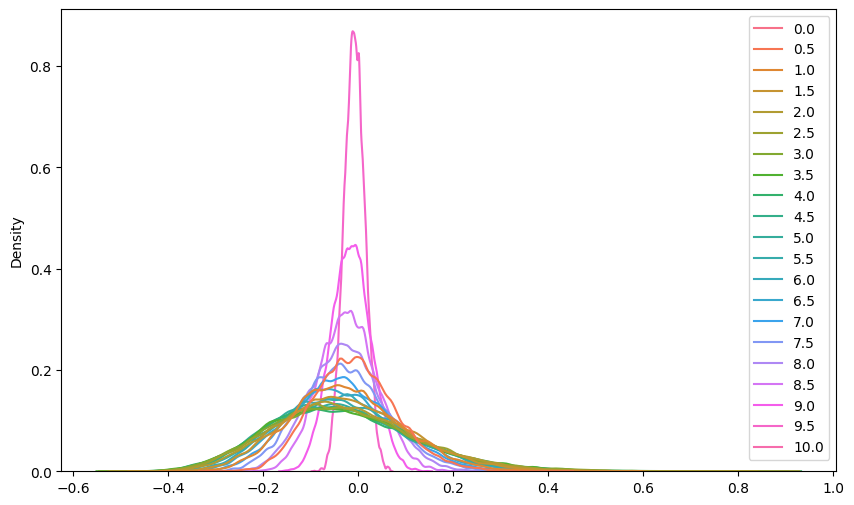

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=MtM_df, bw_adjust=0.5)
plt.show()

Plot the Monte Carlo simulation of MtM

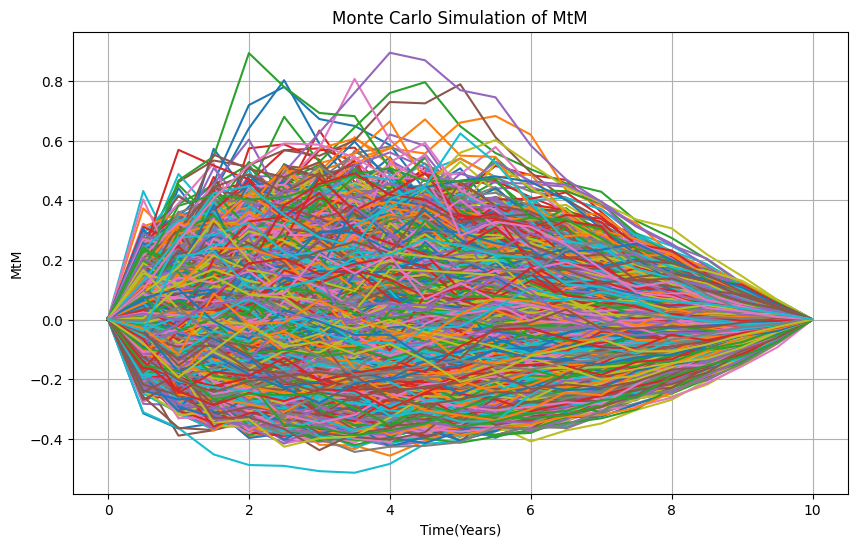

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(MtM_df.T)
plt.title('Monte Carlo Simulation of MtM')
plt.xlabel('Time(Years)')
plt.ylabel('MtM')
plt.grid()
plt.show()

Plot the distribution of MtM

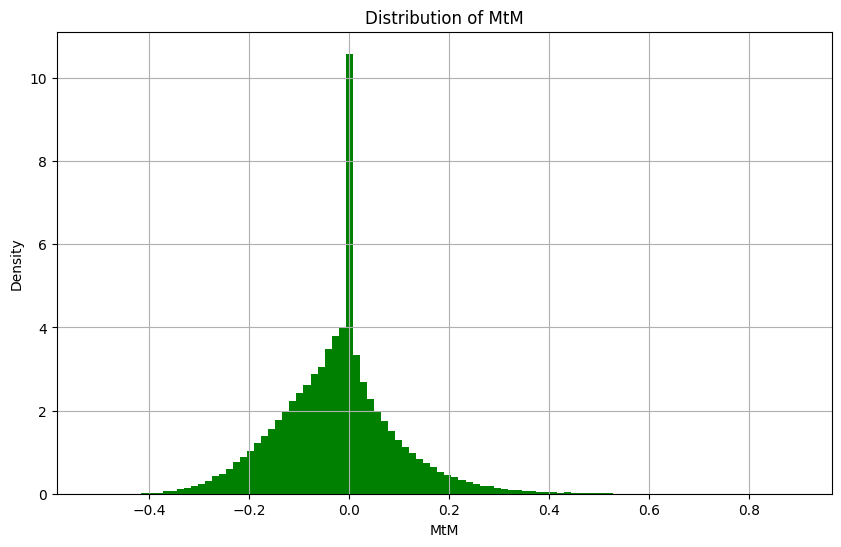

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(MtM_df.values.flatten(), bins=100, density=True, color='g')#.flatten() converts the potentially multi-dimensional array into a one-dimensional array.
plt.title('Distribution of MtM')
plt.xlabel('MtM')
plt.ylabel('Density')
plt.grid()

# **Point 5**

Based on the MtM(t) distributions, calculate the Expected Exposure (EE) and potential future exposure (PFE) at 0.99 confidence level profiles.

## Expected Exposure

$
EE(t) = \mathbb{E}[\max(0, MtM(t))]
$

In [ ]:
def EE_func(MtM, times):
    EE = np.zeros(len(times))
    for i in range(len(times)):
        EE[i] = np.maximum(MtM.iloc[:, i], 0).mean()
    return EE

EE_df = pd.DataFrame(EE_func(MtM_df, Times2), columns=['EE'])
EE_df

EE
0   0.001582
1   0.030529
2   0.035183
3   0.043319
4   0.046165
5   0.047156
6   0.047837
7   0.047390
8   0.046974
9   0.045934
10  0.039651
11  0.041720
12  0.038132
13  0.034326
14  0.029799
15  0.025114
16  0.020378
17  0.015472
18  0.010387
19  0.005267
20  0.000000

## Potential Future Exposure

$
PE(t) = \max\left(0, q(MtM(t), 99\%)\right)
$

In [ ]:
def PFE_func(MtM, times):
    q99 = np.zeros(len(times))
    PFE = np.zeros(len(times))
    for i in range(len(times)):
        q99[i] = np.percentile(MtM.iloc[:, i], 99)
        PFE[i] = np.maximum(q99[i], 0)
    return PFE

PFE_df = pd.DataFrame(PFE_func(MtM_df, Times2), columns=['PFE'])
PFE_df

PFE
0   0.001582
1   0.213976
2   0.260838
3   0.320097
4   0.347349
5   0.370767
6   0.401269
7   0.383817
8   0.378582
9   0.372771
10  0.342500
11  0.328288
12  0.299832
13  0.275826
14  0.236909
15  0.205200
16  0.164791
17  0.124950
18  0.084921
19  0.042679
20  0.000000

## Plot EE, PFE

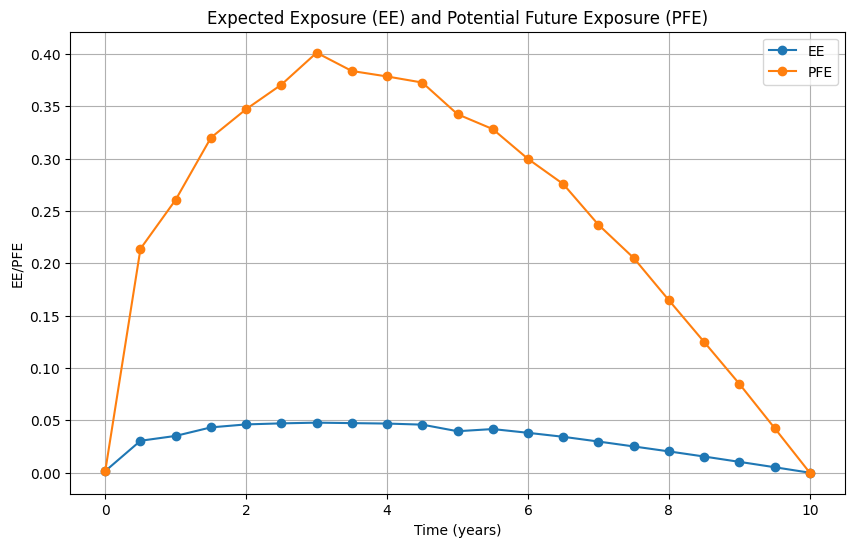

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Times2, EE_df, label='EE', marker='o')
plt.plot(Times2, PFE_df, label='PFE', marker='o')
plt.xlabel('Time (years)')
plt.ylabel('EE/PFE')
plt.title('Expected Exposure (EE) and Potential Future Exposure (PFE)')
plt.legend()
plt.grid()
plt.show()

# **Point 6**

Calculate the CVA price for the interest rate swap traded with a counterparty with the following credit spread curve:

$$
\begin{array}{c|cccccccccc}
\text{T (y)} & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\
\hline
\text{CDS spread (bps)} & 53 & 98 & 122 & 132 & 138 & 142 & 144 & 145 & 146 & 147
\end{array}
$$

The Loss Given Default (LGD) equals 40%. No collateral is applicable.  

**Tasks:**
- What is the CVA sensitivity to the CDS spread?  
- Calculate the CVA price in the case where the CDS spread curve moves 100 bps upwards in parallel.
$$
Write the question here!

## Credit Spread Curve

In [ ]:
times_spread = np.array(range(1, 10+1))
spread = np.array([0.0053, 0.0098, 0.0122, 0.0132, 0.0138, 0.0142, 0.0144, 0.0145, 0.0146, 0.0147])

spread_interpolated = np.interp(Times2, times_spread, spread)

In [ ]:
spread_interpolated_df = pd.DataFrame([Times2, spread_interpolated])
spread_interpolated_df = spread_interpolated_df.transpose()[1:]
spread_interpolated_df.columns = ['Time', 'Spread']
spread_interpolated_df

Time   Spread
1    0.5  0.00530
2    1.0  0.00530
3    1.5  0.00755
4    2.0  0.00980
5    2.5  0.01100
6    3.0  0.01220
7    3.5  0.01270
8    4.0  0.01320
9    4.5  0.01350
10   5.0  0.01380
11   5.5  0.01400
12   6.0  0.01420
13   6.5  0.01430
14   7.0  0.01440
15   7.5  0.01445
16   8.0  0.01450
17   8.5  0.01455
18   9.0  0.01460
19   9.5  0.01465
20  10.0  0.01470

Add spread shock column to the DataFrame

In [ ]:
spread_shock = np.zeros(len(spread_interpolated_df))
for i in range(len(spread_interpolated_df)):
    spread_shock[i] = spread_interpolated_df.iloc[i,1] + 0.01
spread_interpolated_df['Spread Shock'] = spread_shock
spread_interpolated_df

Time   Spread  Spread Shock
1    0.5  0.00530       0.01530
2    1.0  0.00530       0.01530
3    1.5  0.00755       0.01755
4    2.0  0.00980       0.01980
5    2.5  0.01100       0.02100
6    3.0  0.01220       0.02220
7    3.5  0.01270       0.02270
8    4.0  0.01320       0.02320
9    4.5  0.01350       0.02350
10   5.0  0.01380       0.02380
11   5.5  0.01400       0.02400
12   6.0  0.01420       0.02420
13   6.5  0.01430       0.02430
14   7.0  0.01440       0.02440
15   7.5  0.01445       0.02445
16   8.0  0.01450       0.02450
17   8.5  0.01455       0.02455
18   9.0  0.01460       0.02460
19   9.5  0.01465       0.02465
20  10.0  0.01470       0.02470

### Plot CS curve

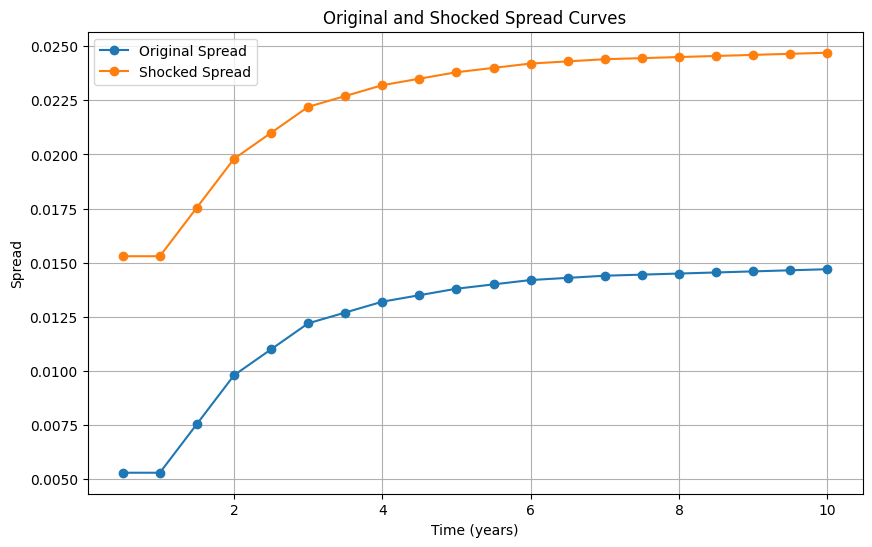

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(spread_interpolated_df['Time'], spread_interpolated_df['Spread'], label='Original Spread', marker='o')
plt.plot(spread_interpolated_df['Time'], spread_interpolated_df['Spread Shock'], label='Shocked Spread', marker='o')
plt.xlabel('Time (years)')
plt.ylabel('Spread')
plt.title('Original and Shocked Spread Curves')
plt.legend()
plt.grid()
plt.show()

## Extract risk-neutral PDs

$\mathrm{PD}(t) = 1 - e^\frac{s*t}{1-RR}.$

$LGD=1-RR$

In [ ]:
lgd = 0.4
# Calculate the PD using the formula
def calculate_PD(spread, time, lgd):
    PD = (1 - np.exp(-spread * time)) / lgd
    return PD

Get risk-neutral PDs

In [ ]:
PD = calculate_PD(spread_interpolated_df['Spread'], spread_interpolated_df['Time'], lgd)
PD

1     0.006616
2     0.013215
3     0.028153
4     0.048523
5     0.067813
6     0.089846
7     0.108691
8     0.128576
9     0.147354
10    0.166683
11    0.185275
12    0.204178
13    0.221902
14    0.239715
15    0.256772
16    0.273812
17    0.290833
18    0.307833
19    0.324811
20    0.341765
dtype: float64

## Compute CVA

$
\mathrm{CVA}
:=\; \mathbb{E}_t\Bigl\{(1-R_C)\,\mathbf{1}_{\,t_C\le\tau_C< T}\;D(t,\tau_C)\;\bigl[\mathrm{MtM}(\tau_C)\bigr]^+\Bigr\}.
$

tau_c is the time of default

$(1-R_c)$ is the LGD and its value is given at $40$%

Discount factors

In [ ]:
disc_fct = np.exp(-interpolated_rates * Times2)
disc_fct

array([1.        , 0.9970045 , 0.99054498, 0.98381983, 0.97579769,
       0.9665111 , 0.95599748, 0.94388589, 0.9305309 , 0.91598985,
       0.90032452, 0.8889627 , 0.87739324, 0.86562802, 0.85367903,
       0.84155829, 0.82927786, 0.81684984, 0.80428628, 0.79159926,
       0.77880078])

CVA Function

In [ ]:
def CVA_func(lgd, discount_factor, MtM_df, PD):
    CVA = 0
    for i in range(1, len(spread_interpolated_df['Time'])):
        CVA += np.mean(lgd * discount_factor[i] * np.maximum(MtM_df.iloc[:, i], 0)) *PD[i]  # sum of the mean of the raws for each time step times the related pd at that time step
    return CVA

Compute CVA

In [ ]:
CVA = CVA_func(lgd, disc_fct, MtM_df, PD)
CVA

np.float64(0.031171693364643125)

## Compute Shocked CVA

Get shocked risk-neutral probabilities

In [ ]:
PD_shock = calculate_PD(spread_interpolated_df['Spread Shock'], spread_interpolated_df['Time'], lgd)
PD_shock

1     0.019052
2     0.037959
3     0.064954
4     0.097065
5     0.127864
6     0.161077
7     0.190939
8     0.221561
9     0.250876
10    0.280480
11    0.309148
12    0.337877
13    0.365269
14    0.392525
15    0.418860
16    0.444969
17    0.470853
18    0.496510
19    0.521942
20    0.547148
dtype: float64

Compute shocked CVA

In [ ]:
CVA_shock = CVA_func(lgd, disc_fct, MtM_df, PD_shock)
CVA_shock

np.float64(0.05331485619113833)

## CVA sensitivity to CDS spread

In [ ]:
delta_cva = (CVA_shock - CVA) / CVA
delta_cva

np.float64(0.7103612424088374)

# **Point 7**

Calculate the FVA price for this transaction, with $s_F$ – the funding spread on top of risk-free rate – equal to 0.4%.


## Compute FVA

$
\mathrm{FVA}
:=\; \mathbb{E}_t\Bigl\{S_f\,\mathbf{1}_{\,t_C\le\tau_C< T}\;D(t,\tau_C)\;\bigl[\mathrm{MtM}(\tau_C)\bigr]^+\Bigr\}.
$

$S_f$ is the funding spread on top of the risk free rate fixed at 0.004

In [ ]:
sf = 0.004

def FVA_func(sf, MtM_df, discount_factors, PD):
    FVA = 0
    for i in range(1, len(spread_interpolated_df['Time'])):
        FVA += np.mean(sf * discount_factors[i] * np.maximum(MtM_df.iloc[:, i], 0)) *PD[i]
    return FVA

In [ ]:
FVA = FVA_func(sf, MtM_df, disc_fct, PD)
FVA

np.float64(0.0003117169336464312)

# **Point 8**

Now suppose that the trade is collateralized, i.e. we (the bank) are asking for collateral (variation margin) from our counterparty to cover/offset the counterparty exposure. Suppose daily margining and immediate collateral transfer. This means that on each of the repricing dates we are fully collateralized and exposed only over the **Margin Period of Risk (MPOR)**.

In our example the $MPOR = 10d$.

**(a)** Calculate the EE, PFE, CVA and FVA for this collateralized trade.  
**(b)** Comment on what is the impact of collateral on CVA and FVA.


## Get times daily

In [ ]:
times_daily = np.array(range(0, len(rates.columns)))
times_daily = times_daily.tolist() # convert to list
times_daily[-1]
times_daily_annualized = np.array(times_daily) / 252

## Get daily discount factors

In [ ]:
rate_inter_daily =np.interp(times_daily_annualized,Times,IR) # we start to interpolate from the first time in Times, therefore the first rates are the same
rate_inter_daily

array([0.0025    , 0.0025    , 0.0025    , ..., 0.02499365, 0.02499683,
       0.025     ])

Daily discount factors

In [ ]:
discount_factors_daily = np.exp(-rate_inter_daily*times_daily_annualized)
discount_factors_daily

array([1.        , 0.99999008, 0.99998016, ..., 0.77900474, 0.77890277,
       0.77880078])

## MtM daily

In [ ]:
MtM_daily = np.zeros((n_path, len(times_daily)))

for i in range(n_path):
    MtM_daily[i, :] = np.interp(times_daily_annualized, Times2, MtM_df.iloc[i, :])
MtM_daily_df = pd.DataFrame(MtM_daily, columns=times_daily)
MtM_daily_df

0         1         2         3         4         5         6     \
0     0.001582  0.002794  0.004006  0.005218  0.006430  0.007643  0.008855   
1     0.001582  0.000712 -0.000158 -0.001027 -0.001897 -0.002766 -0.003636   
2     0.001582  0.001820  0.002058  0.002295  0.002533  0.002771  0.003009   
3     0.001582  0.001266  0.000951  0.000635  0.000320  0.000004 -0.000311   
4     0.001582  0.001330  0.001078  0.000826  0.000574  0.000322  0.000070   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.001582  0.000562 -0.000459 -0.001479 -0.002499 -0.003519 -0.004539   
9996  0.001582  0.002377  0.003171  0.003966  0.004761  0.005555  0.006350   
9997  0.001582  0.001525  0.001467  0.001410  0.001353  0.001296  0.001238   
9998  0.001582  0.000937  0.000291 -0.000354 -0.000999 -0.001644 -0.002289   
9999  0.001582  0.001264  0.000946  0.000628  0.000310 -0.000008 -0.000326   

          7         8         9     ...      2511      2512      2513  \
0     0.010067  0.011279  0.012491  ...  0.001488  0.001323  0.001157   
1    -0.004506 -0.005375 -0.006245  ... -0.004697 -0.004175 -0.003653   
2     0.003247  0.003485  0.003723  ...  0.002046  0.001819  0.001591   
3    -0.000627 -0.000942 -0.001258  ...  0.000214  0.000190  0.000166   
4    -0.000182 -0.000433 -0.000685  ... -0.003387 -0.003011 -0.002635   
...        ...       ...       ...  ...       ...       ...       ...   
9995 -0.005560 -0.006580 -0.007600  ...  0.000272  0.000242  0.000212   
9996  0.007145  0.007939  0.008734  ...  0.000620  0.000551  0.000482   
9997  0.001181  0.001124  0.001067  ... -0.001125 -0.001000 -0.000875   
9998 -0.002934 -0.003580 -0.004225  ... -0.001801 -0.001601 -0.001401   
9999 -0.000644 -0.000962 -0.001280  ...  0.001446  0.001285  0.001125   

          2514      2515      2516      2517      2518      2519  2520  
0     0.000992  0.000827  0.000661  0.000496  0.000331  0.000165   0.0  
1    -0.003131 -0.002609 -0.002088 -0.001566 -0.001044 -0.000522   0.0  
2     0.001364  0.001137  0.000909  0.000682  0.000455  0.000227   0.0  
3     0.000142  0.000119  0.000095  0.000071  0.000047  0.000024   0.0  
4    -0.002258 -0.001882 -0.001505 -0.001129 -0.000753 -0.000376   0.0  
...        ...       ...       ...       ...       ...       ...   ...  
9995  0.000181  0.000151  0.000121  0.000091  0.000060  0.000030   0.0  
9996  0.000413  0.000345  0.000276  0.000207  0.000138  0.000069   0.0  
9997 -0.000750 -0.000625 -0.000500 -0.000375 -0.000250 -0.000125   0.0  
9998 -0.001201 -0.001001 -0.000801 -0.000600 -0.000400 -0.000200   0.0  
9999  0.000964  0.000803  0.000643  0.000482  0.000321  0.000161   0.0  

[10000 rows x 2521 columns]

#### Plot Daily MtM

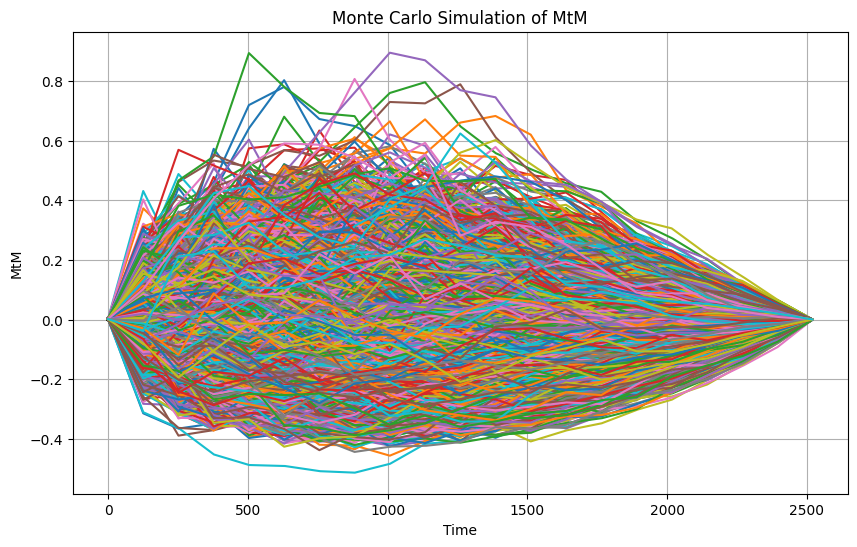

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(MtM_daily_df.T)
plt.title('Monte Carlo Simulation of MtM')
plt.xlabel('Time')
plt.ylabel('MtM')
plt.grid()
plt.show()

## Collateral

Populate the array with MtM_daily_df values every MPOR days

In [ ]:
MPOR = 10
times_MPOR = np.array(range(0, int(len(times_daily)/MPOR)))

Collateral = np.zeros((n_path, int(len(MtM_daily_df.columns) / MPOR)))

for i in range(n_path):
    for j in range(int(len(MtM_daily_df.columns) / MPOR)):
        index = int(j * MPOR)
        Collateral[i, j] = MtM_daily_df.iloc[i, index]

Collateral_df = pd.DataFrame(Collateral)
Collateral_df

0         1         2         3         4         5         6    \
0     0.001582  0.013703  0.025825  0.037947  0.050068  0.062190  0.074312   
1     0.001582 -0.007115 -0.015811 -0.024508 -0.033205 -0.041901 -0.050598   
2     0.001582  0.003961  0.006339  0.008718  0.011097  0.013476  0.015854   
3     0.001582 -0.001573 -0.004728 -0.007883 -0.011038 -0.014193 -0.017348   
4     0.001582 -0.000937 -0.003456 -0.005975 -0.008495 -0.011014 -0.013533   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.001582 -0.008620 -0.018822 -0.029024 -0.039226 -0.049428 -0.059630   
9996  0.001582  0.009529  0.017476  0.025423  0.033370  0.041317  0.049264   
9997  0.001582  0.001010  0.000437 -0.000135 -0.000707 -0.001280 -0.001852   
9998  0.001582 -0.004870 -0.011322 -0.017774 -0.024225 -0.030677 -0.037129   
9999  0.001582 -0.001598 -0.004779 -0.007959 -0.011139 -0.014320 -0.017500   

           7         8         9    ...       242       243       244  \
0     0.086433  0.098555  0.110677  ...  0.016532  0.014879  0.013226   
1    -0.059294 -0.067991 -0.076688  ... -0.052189 -0.046970 -0.041752   
2     0.018233  0.020612  0.022991  ...  0.022732  0.020459  0.018186   
3    -0.020503 -0.023658 -0.026813  ...  0.002374  0.002137  0.001899   
4    -0.016052 -0.018571 -0.021090  ... -0.037637 -0.033873 -0.030109   
...        ...       ...       ...  ...       ...       ...       ...   
9995 -0.069832 -0.080033 -0.090235  ...  0.003023  0.002721  0.002418   
9996  0.057211  0.065159  0.073106  ...  0.006890  0.006201  0.005512   
9997 -0.002424 -0.002996 -0.003569  ... -0.012495 -0.011245 -0.009996   
9998 -0.043581 -0.050033 -0.056484  ... -0.020016 -0.018015 -0.016013   
9999 -0.020680 -0.023860 -0.027041  ...  0.016066  0.014459  0.012853   

           245       246       247       248       249       250       251  
0     0.011573  0.009919  0.008266  0.006613  0.004960  0.003306  0.001653  
1    -0.036533 -0.031314 -0.026095 -0.020876 -0.015657 -0.010438 -0.005219  
2     0.015912  0.013639  0.011366  0.009093  0.006820  0.004546  0.002273  
3     0.001662  0.001424  0.001187  0.000950  0.000712  0.000475  0.000237  
4    -0.026346 -0.022582 -0.018818 -0.015055 -0.011291 -0.007527 -0.003764  
...        ...       ...       ...       ...       ...       ...       ...  
9995  0.002116  0.001814  0.001511  0.001209  0.000907  0.000605  0.000302  
9996  0.004823  0.004134  0.003445  0.002756  0.002067  0.001378  0.000689  
9997 -0.008746 -0.007497 -0.006247 -0.004998 -0.003748 -0.002499 -0.001249  
9998 -0.014011 -0.012010 -0.010008 -0.008007 -0.006005 -0.004003 -0.002002  
9999  0.011246  0.009639  0.008033  0.006426  0.004820  0.003213  0.001607  

[10000 rows x 252 columns]

In [ ]:
np.mean(Collateral_df.iloc[:, 1]) % np.mean(MtM_daily_df.iloc[:, 10]) #check if the values are the same

np.float64(0.0)

## Net Exposure

$(MtM(t)-Collateral(t))^+$

In [ ]:
Net_Exposure = np.zeros((n_path, len(times_daily)))
for i in range(n_path):
    for j in range(len(times_daily)):
        if j % MPOR == 0:
            Net_Exposure[i,j] = 0
        else:
            idx_col = np.searchsorted(times_MPOR, times_daily[j]/MPOR, side='right') -1
            Net_Exposure[i,j] = np.maximum(MtM_daily_df.iloc[i,j] - Collateral_df.iloc[i, idx_col],0)

Net_Exposure_df = pd.DataFrame(Net_Exposure, columns=times_daily)

Net_Exposure_df

0         1         2         3         4         5         6     \
0      0.0  0.001212  0.002424  0.003636  0.004849  0.006061  0.007273   
1      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2      0.0  0.000238  0.000476  0.000714  0.000952  0.001189  0.001427   
3      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...    ...       ...       ...       ...       ...       ...       ...   
9995   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9996   0.0  0.000795  0.001589  0.002384  0.003179  0.003974  0.004768   
9997   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9998   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9999   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          7         8         9     ...      2511      2512      2513  \
0     0.008485  0.009697  0.010909  ...  0.000000  0.000000  0.000000   
1     0.000000  0.000000  0.000000  ...  0.000522  0.001044  0.001566   
2     0.001665  0.001903  0.002141  ...  0.000000  0.000000  0.000000   
3     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
4     0.000000  0.000000  0.000000  ...  0.000376  0.000753  0.001129   
...        ...       ...       ...  ...       ...       ...       ...   
9995  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
9996  0.005563  0.006358  0.007152  ...  0.000000  0.000000  0.000000   
9997  0.000000  0.000000  0.000000  ...  0.000125  0.000250  0.000375   
9998  0.000000  0.000000  0.000000  ...  0.000200  0.000400  0.000600   
9999  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

          2514      2515      2516      2517      2518      2519  2520  
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0  
1     0.002088  0.002609  0.003131  0.003653  0.004175  0.004697   0.0  
2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0  
3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0  
4     0.001505  0.001882  0.002258  0.002635  0.003011  0.003387   0.0  
...        ...       ...       ...       ...       ...       ...   ...  
9995  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0  
9996  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0  
9997  0.000500  0.000625  0.000750  0.000875  0.001000  0.001125   0.0  
9998  0.000801  0.001001  0.001201  0.001401  0.001601  0.001801   0.0  
9999  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0  

[10000 rows x 2521 columns]

## Exposure

$(MtM(t+MPOR)-MtM(t))^+$

In [ ]:
Exposure = np.zeros((n_path, len(times_daily)))
for i in range(n_path):
    for j in range(len(times_daily)-MPOR):
        Exposure[i,j] = np.maximum(MtM_daily_df.iloc[i,j+MPOR] - MtM_daily_df.iloc[i, j], 0)
Exposure_df = pd.DataFrame(Exposure, columns=times_daily)
Exposure_df

0         1         2         3         4         5         6     \
0     0.012122  0.012122  0.012122  0.012122  0.012122  0.012122  0.012122   
1     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2     0.002379  0.002379  0.002379  0.002379  0.002379  0.002379  0.002379   
3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9996  0.007947  0.007947  0.007947  0.007947  0.007947  0.007947  0.007947   
9997  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9998  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9999  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          7         8         9     ...  2511  2512  2513  2514  2515  2516  \
0     0.012122  0.012122  0.012122  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1     0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2     0.002379  0.002379  0.002379  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3     0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0   0.0   0.0   
4     0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0   0.0   0.0   
...        ...       ...       ...  ...   ...   ...   ...   ...   ...   ...   
9995  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0   0.0   0.0   
9996  0.007947  0.007947  0.007947  ...   0.0   0.0   0.0   0.0   0.0   0.0   
9997  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0   0.0   0.0   
9998  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0   0.0   0.0   
9999  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0   0.0   0.0   

      2517  2518  2519  2520  
0      0.0   0.0   0.0   0.0  
1      0.0   0.0   0.0   0.0  
2      0.0   0.0   0.0   0.0  
3      0.0   0.0   0.0   0.0  
4      0.0   0.0   0.0   0.0  
...    ...   ...   ...   ...  
9995   0.0   0.0   0.0   0.0  
9996   0.0   0.0   0.0   0.0  
9997   0.0   0.0   0.0   0.0  
9998   0.0   0.0   0.0   0.0  
9999   0.0   0.0   0.0   0.0  

[10000 rows x 2521 columns]

## Collateralized EE Method 1

In [ ]:
Coll_EE_df = pd.DataFrame(EE_func(Net_Exposure_df, times_daily), columns=['Collateralized EE'])
Coll_EE_df


Collateralized EE
0              0.000000
1              0.000237
2              0.000473
3              0.000710
4              0.000947
...                 ...
2516           0.000642
2517           0.000749
2518           0.000856
2519           0.000963
2520           0.000000

[2521 rows x 1 columns]

## Collateralized EE Method 2

In [ ]:
Coll_EE_df2 = pd.DataFrame(EE_func(Exposure_df, times_daily), columns=['Collateralized EE'])
Coll_EE_df2

Collateralized EE
0              0.002367
1              0.002367
2              0.002367
3              0.002367
4              0.002367
...                 ...
2516           0.000000
2517           0.000000
2518           0.000000
2519           0.000000
2520           0.000000

[2521 rows x 1 columns]

## Collateralized PFE Method 1

In [ ]:
Coll_PFE_df = pd.DataFrame(PFE_func(Net_Exposure_df, times_daily), columns=['Collateralized PFE'])
Coll_PFE_df

Collateralized PFE
0               0.000000
1               0.001686
2               0.003371
3               0.005057
4               0.006743
...                  ...
2516            0.002755
2517            0.003215
2518            0.003674
2519            0.004133
2520            0.000000

[2521 rows x 1 columns]

## Collateralized PFE Method 2

In [ ]:
Coll_PFE_df2 = pd.DataFrame(PFE_func(Exposure_df, times_daily), columns=['Collateralized PFE'])
Coll_PFE_df2

Collateralized PFE
0               0.016857
1               0.016857
2               0.016857
3               0.016857
4               0.016857
...                  ...
2516            0.000000
2517            0.000000
2518            0.000000
2519            0.000000
2520            0.000000

[2521 rows x 1 columns]

## Plot Collateralized EE & PFE

Plot Collateralized Expected Exposure Method 1

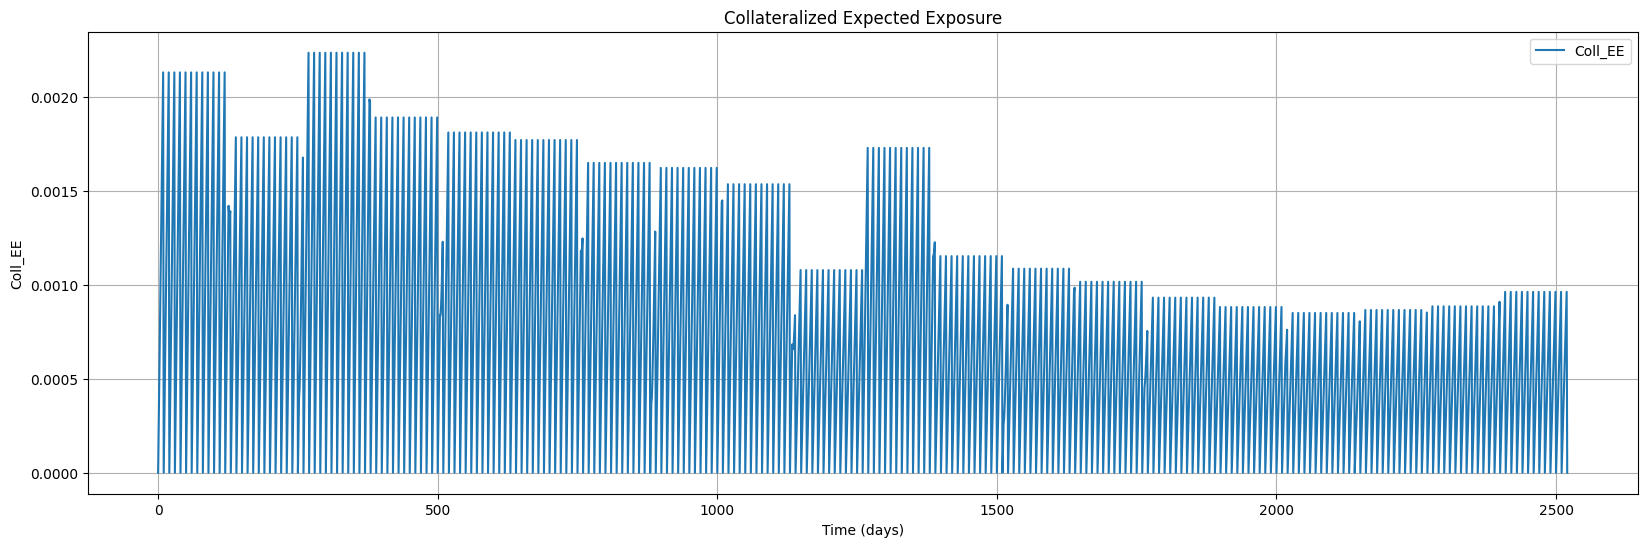

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(times_daily, Coll_EE_df, label='Coll_EE')
plt.xlabel('Time (days)')
plt.ylabel('Coll_EE')
plt.title('Collateralized Expected Exposure')
plt.legend()
plt.grid()
plt.show()

Plot Collateralized Expected Exposure Method 2

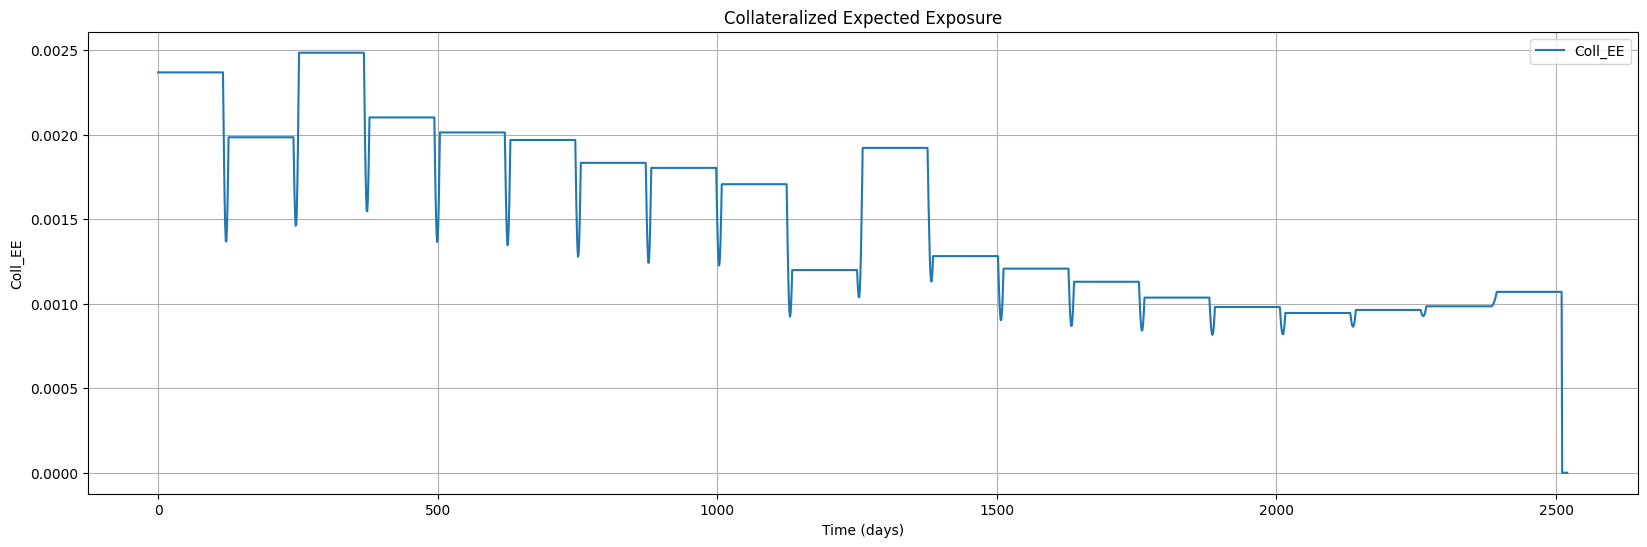

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(times_daily, Coll_EE_df2, label='Coll_EE')
plt.xlabel('Time (days)')
plt.ylabel('Coll_EE')
plt.title('Collateralized Expected Exposure')
plt.legend()
plt.grid()
plt.show()

Plot 6m Collateralized Expected Exposure Method 1

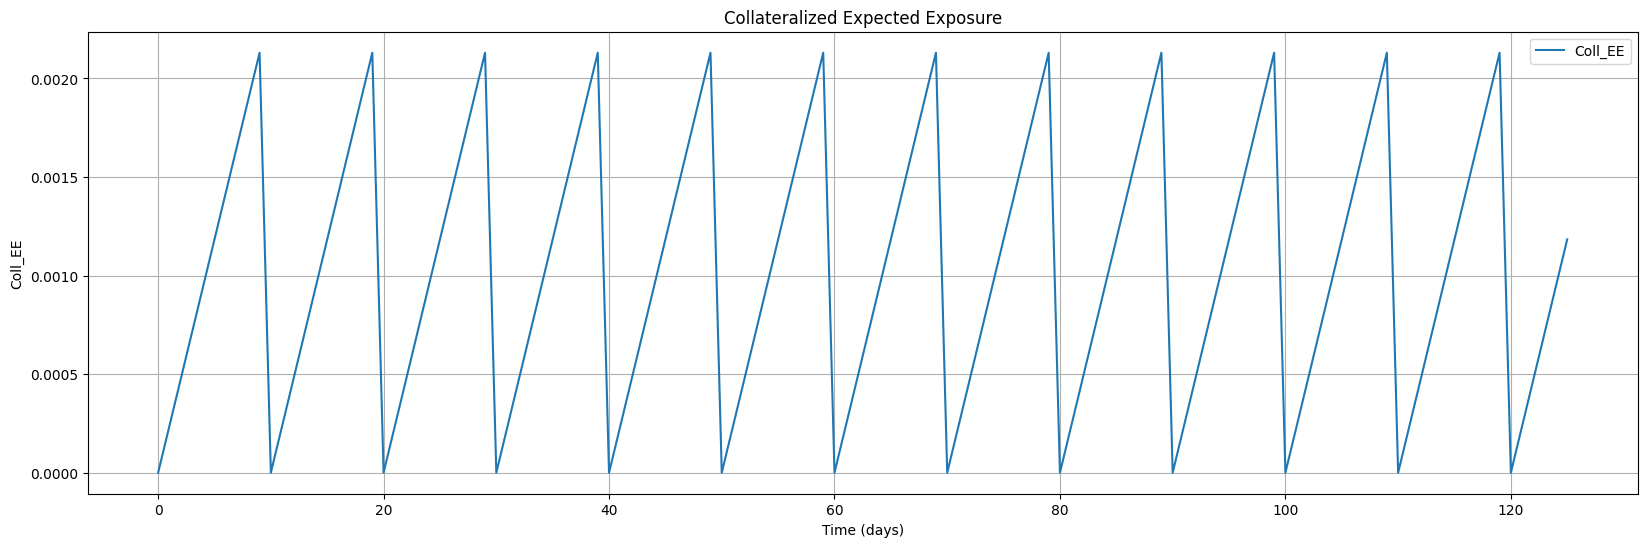

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(times_daily[:126], Coll_EE_df.iloc[:126], label='Coll_EE')
plt.xlabel('Time (days)')
plt.ylabel('Coll_EE')
plt.title('Collateralized Expected Exposure')
plt.legend()
plt.grid()
plt.show()

Plot Collateralized Potential Future Exposure (PFE) Method 1

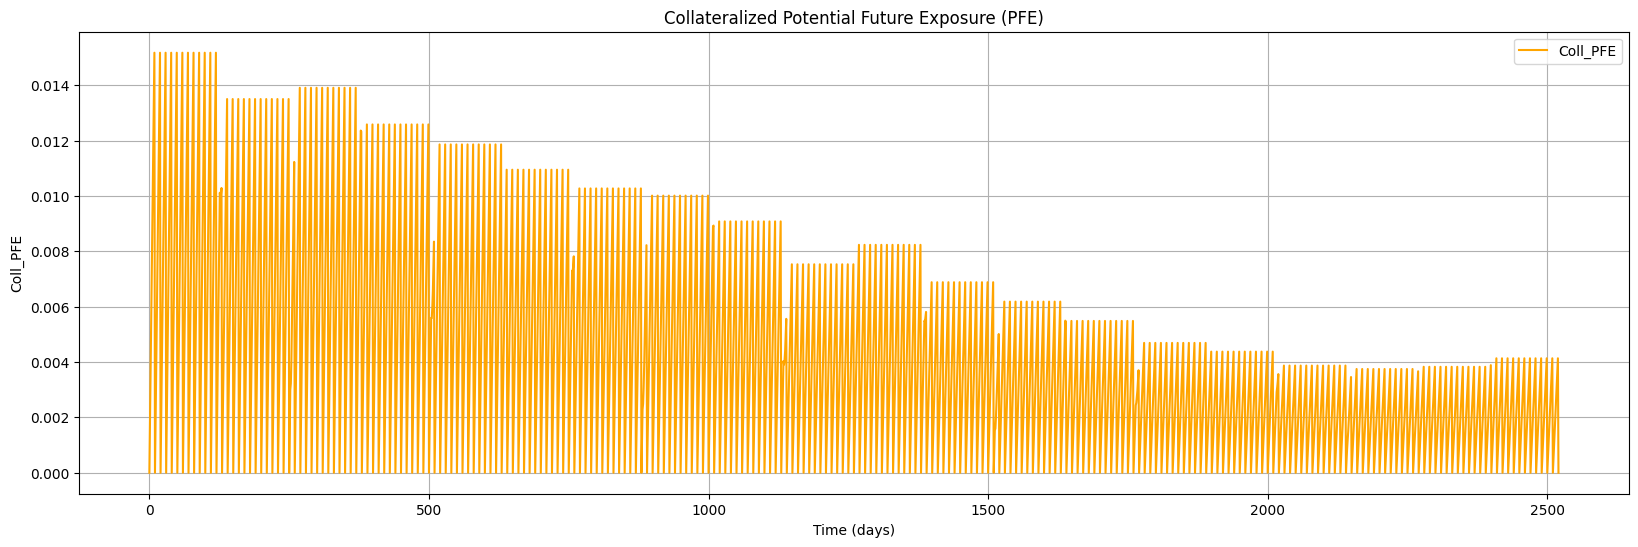

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(times_daily, Coll_PFE_df, label='Coll_PFE', color='orange')
plt.xlabel('Time (days)')
plt.ylabel('Coll_PFE')
plt.title('Collateralized Potential Future Exposure (PFE)')
plt.legend()
plt.grid()
plt.show()

Plot Collateralized Potential Future Exposure (PFE) Method 2

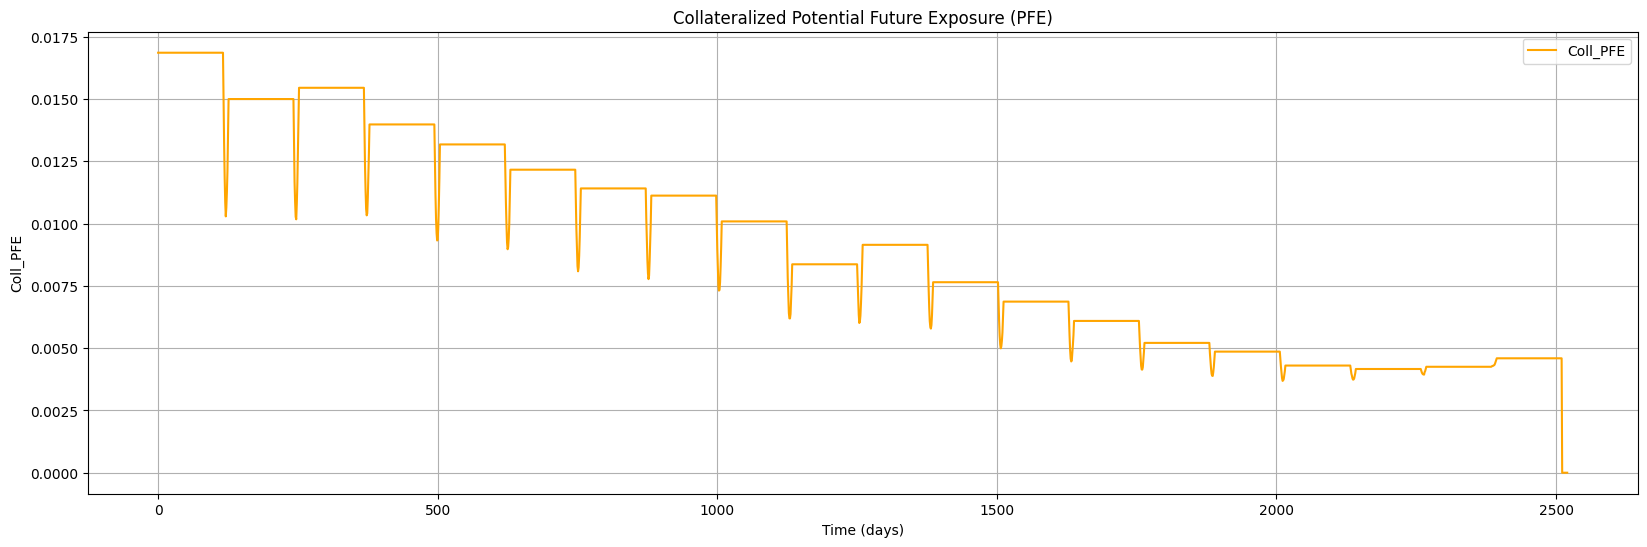

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(times_daily, Coll_PFE_df2, label='Coll_PFE', color='orange')
plt.xlabel('Time (days)')
plt.ylabel('Coll_PFE')
plt.title('Collateralized Potential Future Exposure (PFE)')
plt.legend()
plt.grid()
plt.show()

Plot 6m Collateralized Potential Future Exposure (PFE) Method 1

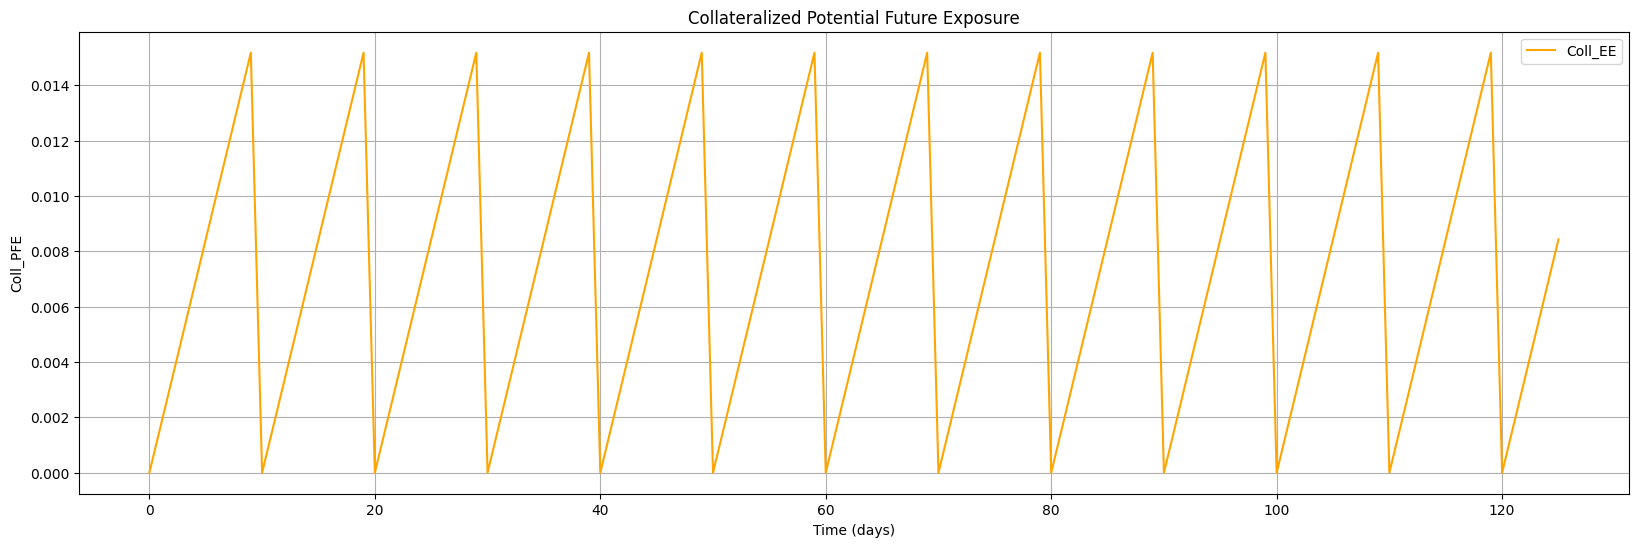

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(times_daily[:126], Coll_PFE_df.iloc[:126], label='Coll_EE', color='orange')
plt.xlabel('Time (days)')
plt.ylabel('Coll_PFE')
plt.title('Collateralized Potential Future Exposure')
plt.legend()
plt.grid()
plt.show()

## Daily Credit Spread curve

In [ ]:
spread_interp_daily = np.interp(times_daily, times_spread, spread)

In [ ]:
spread_interp_daily_df = pd.DataFrame([times_daily_annualized, spread_interp_daily])
spread_interp_daily_df = spread_interp_daily_df.transpose()[1:]
spread_interp_daily_df.columns = ['Time', 'Spread']
spread_interp_daily_df

Time  Spread
1      0.003968  0.0053
2      0.007937  0.0098
3      0.011905  0.0122
4      0.015873  0.0132
5      0.019841  0.0138
...         ...     ...
2516   9.984127  0.0147
2517   9.988095  0.0147
2518   9.992063  0.0147
2519   9.996032  0.0147
2520  10.000000  0.0147

[2520 rows x 2 columns]

## Daily PDs

In [ ]:
PD_daily = calculate_PD(spread_interp_daily_df['Spread'], spread_interp_daily_df['Time'], lgd)
PD_daily

1       0.000053
2       0.000194
3       0.000363
4       0.000524
5       0.000684
          ...   
2516    0.341261
2517    0.341387
2518    0.341513
2519    0.341639
2520    0.341765
Length: 2520, dtype: float64

## CVA

CVA Method 1

In [ ]:
Coll_CVA = CVA_func(lgd, discount_factors_daily, Net_Exposure_df, PD_daily)
Coll_CVA

np.float64(1.3935732509226959e-05)

CVA Method 2

In [ ]:
Coll_CVA = CVA_func(lgd, discount_factors_daily, Exposure_df, PD_daily)
Coll_CVA

np.float64(2.580414467571269e-05)

## FVA

FVA Method 1

In [ ]:
Coll_FVA = FVA_func(sf, Net_Exposure_df, discount_factors_daily, PD_daily)
Coll_FVA

np.float64(1.3935732509226958e-07)

FVA Method 2

In [ ]:
Coll_FVA = FVA_func(sf, Exposure_df, discount_factors_daily, PD_daily)
Coll_FVA

np.float64(2.5804144675712686e-07)

# Point 9

Implement a Geometric Brownian Motion stochastic model with the stochastic rates as per above as drift. With 10,000 scenarios for a share price starting at \$100, calculate FVA for short positions (-1) on down-and-in put options with strike at \$100, maturity 1.5 years and the following barrier levels: \{50, 55, 60, 65, 70, 75, 80\}\$.

The same funding spread as per above applies and the volatility, for the share price random paths and the corresponding options to price, equals $\sigma = 0.30$.


## Simulate the underlying

$
S_{i} = S_{i-1} \cdot \exp\left( \left( r_{i-1} - \frac{1}{2} \sigma^2 \right) \Delta t + \sigma \sqrt{\Delta t} \cdot Z_i \right)
$

Where:
- $S_i$ is the simulated stock price at step $i$
- $r_{i-1}$ is the stochastic short rate at time step $i-1$
- $\sigma$ is the volatility ($\sigma = 0.30$)
- $\Delta t = \frac{1}{252}$ is the daily time step
- $Z_i \sim \mathcal{N}(0,1)$ is a standard normal random variable

In [ ]:
sigma = 0.3
times_options = times_daily[0:378]
S = np.zeros((n_path, len(times_options)))
S[:,0] = 100
dt = 1/252

for i in range(1, len(times_options)):
    Z = np.random.normal(0,1,n_path)
    S[:,i] = S[:,i-1] *np.exp((rates.iloc[:,i-1] -sigma**2/2) *dt +sigma *np.sqrt(dt)*Z)

S_df = pd.DataFrame(S)
S_df

0           1           2           3           4           5    \
0     100.0  100.277262  102.672907  103.230538  105.755330  106.639589   
1     100.0   99.458859  100.528913   96.839804   98.876601   96.127340   
2     100.0   98.033202   95.195451   96.435884   95.094356   97.015529   
3     100.0  100.461317   98.820599   99.770724   96.728697   99.850224   
4     100.0  100.353700   98.479290  101.281622  102.039497  101.248467   
...     ...         ...         ...         ...         ...         ...   
9995  100.0  101.459642  101.631093  103.343792  101.859524  104.094163   
9996  100.0   96.713148   97.514242  100.109281  100.739476  100.824457   
9997  100.0  101.287745  102.001651  102.038759  101.767105   99.806338   
9998  100.0   99.066302   98.900208   99.474082   97.996056   98.176243   
9999  100.0   99.756908   96.182687   96.727853   96.249985   96.074817   

             6           7           8           9    ...         368  \
0     104.940232  106.621017  105.888959  107.157887  ...   80.318837   
1      95.269916   95.329696   94.228165   94.036837  ...   80.539026   
2      98.538394   98.987188   98.129485  100.353220  ...   61.130214   
3     103.055688  102.432691  100.494780  101.597857  ...   77.293317   
4     102.370445  100.356254  100.479411  102.905808  ...  111.885316   
...          ...         ...         ...         ...  ...         ...   
9995  103.517932  100.229913  100.448548  103.224920  ...  122.277050   
9996   98.881128   94.953446   95.033284   96.907554  ...  100.298144   
9997   99.625506   96.736514   97.767276   98.451064  ...  117.955365   
9998   97.825270   99.304826   99.089557   97.594526  ...   82.346677   
9999   93.800866   90.914492   90.339808   90.988310  ...  144.527240   

             369         370         371         372         373         374  \
0      78.972677   78.718898   76.878599   77.412730   78.509045   77.121263   
1      81.547494   83.004770   83.038975   85.356428   83.691556   82.956497   
2      61.760586   62.108103   60.507724   61.909915   62.348676   61.973170   
3      76.434667   76.477509   75.382100   76.353488   79.136791   80.841095   
4     114.324404  109.676053  108.096131  108.549411  108.183813  108.856272   
...          ...         ...         ...         ...         ...         ...   
9995  120.651992  119.361768  117.371762  115.370741  115.570770  114.847467   
9996   97.715593   99.014910   99.562896  100.462197  102.356509   98.800928   
9997  120.541236  126.180491  126.569431  127.988602  126.599139  131.457124   
9998   84.243345   82.842111   83.423903   84.181453   82.816524   83.505309   
9999  148.065104  145.183548  147.843422  147.540150  145.399129  142.293258   

             375         376         377  
0      77.749066   78.282154   75.576289  
1      82.181467   84.071661   81.700749  
2      60.239789   60.197277   62.584438  
3      79.402298   80.815679   83.076913  
4     108.367315  112.598945  109.721004  
...          ...         ...         ...  
9995  108.250981  110.870143  109.575732  
9996   98.471578   98.435716   96.939039  
9997  126.861128  126.925052  126.701844  
9998   85.726942   87.138635   87.634638  
9999  144.605949  143.846405  141.546110  

[10000 rows x 378 columns]

### Plot the simulated underlying

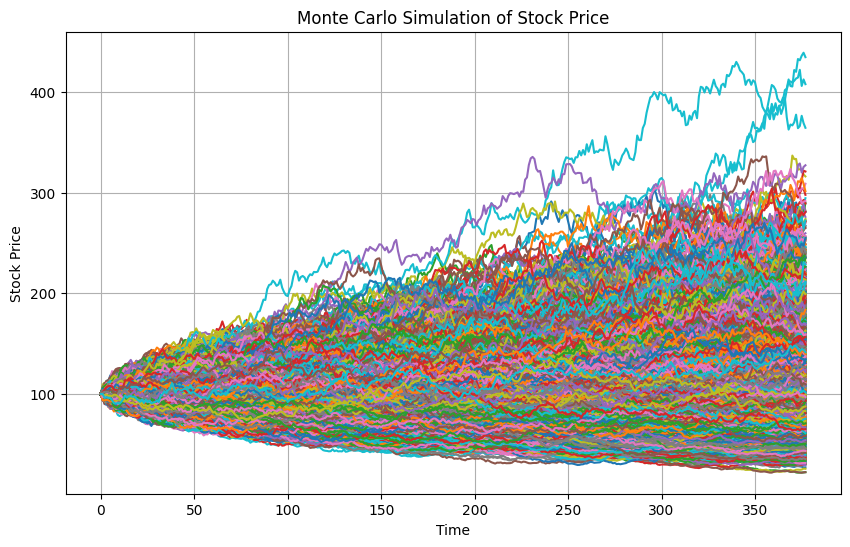

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(S_df.T)
plt.title('Monte Carlo Simulation of Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid()
plt.show()

## MtM with Least Squares Monte Carlo

In [ ]:
K = 100                      # Strike price
barrier=50                  # Barrier
T = 1.5                     # Maturity
n_paths, n_steps = S_df.shape
barrier_hit = S_df.le(barrier).any(axis=1)
#Extract final prices column
final_prices = S_df.iloc[:, -1]
# Final Payoff
payoff = ((K - final_prices).clip(lower=0)).where(barrier_hit, 0)
# Initialize MtM dataframe
mtm_df = pd.DataFrame(0.0, index=S_df.index, columns=S_df.columns)
r_discount_daily = rate_inter_daily[0:378]
#backward regression Least Squares Monte Carlo
for t in reversed(range(n_steps - 1)):
    S_t = S_df.iloc[:, t]
    time_to_maturity = T - t * dt
    discount = np.exp(-r_discount_daily[t] * time_to_maturity)
    discounted_payoff = payoff * discount

    # Variable H (1 if the barrier have been touched, 0 otherwise)
    barrier_hit_up_to_t = S_df.iloc[:, :t+1].le(barrier).any(axis=1).astype(int)
    H = barrier_hit_up_to_t
    H2 = H ** 2

    # Regression
    X = pd.DataFrame({
        'S': S_t,
        'S2': S_t ** 2,
        'H': H,
        'H2': H2
    })

    model = LinearRegression().fit(X, discounted_payoff)
    continuation_value = model.predict(X)

    # MtM:
    mtm_df.iloc[:, t] = np.maximum(continuation_value, 0)

# Price at inception
initial_price = mtm_df.iloc[0, 0]

# Calculation of the variation
short_position = initial_price - mtm_df

FVA50= FVA_func(sf, short_position, r_discount_daily, PD )
FVA50

np.float64(1.680635997829986e-05)

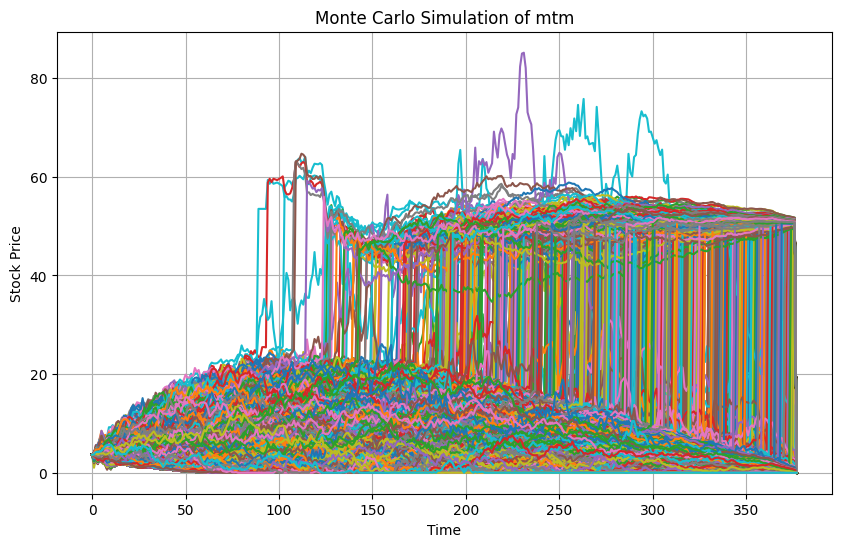

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mtm_df.T)
plt.title('Monte Carlo Simulation of mtm')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid()
plt.show()



In [ ]:
K = 100                      # Strike price
barrier=55                  # Barrier
T = 1.5                     # Maturity
n_paths, n_steps = S_df.shape
barrier_hit = S_df.le(barrier).any(axis=1)

final_prices = S_df.iloc[:, -1]

payoff = ((K - final_prices).clip(lower=0)).where(barrier_hit, 0)

mtm_df = pd.DataFrame(0.0, index=S_df.index, columns=S_df.columns)
r_discount_daily = rate_inter_daily[0:378]

for t in reversed(range(n_steps - 1)):
    S_t = S_df.iloc[:, t]
    time_to_maturity = T - t * dt
    discount = np.exp(-r_discount_daily[t] * time_to_maturity)
    discounted_payoff = payoff * discount


    barrier_hit_up_to_t = S_df.iloc[:, :t+1].le(barrier).any(axis=1).astype(int)
    H = barrier_hit_up_to_t
    H2 = H ** 2

    X = pd.DataFrame({
        'S': S_t,
        'S2': S_t ** 2,
        'H': H,
        'H2': H2
    })

    model = LinearRegression().fit(X, discounted_payoff)
    continuation_value = model.predict(X)


    mtm_df.iloc[:, t] = np.maximum(continuation_value, 0)


initial_price = mtm_df.iloc[0, 0]

short_position = initial_price - mtm_df

FVA55= FVA_func(sf, short_position, r_discount_daily, PD )
FVA55


np.float64(2.281379285886081e-05)

In [ ]:
K = 100                      # Strike price
barrier=60                  # Barrier
T = 1.5                     # Maturity
n_paths, n_steps = S_df.shape
barrier_hit = S_df.le(barrier).any(axis=1)

final_prices = S_df.iloc[:, -1]

payoff = ((K - final_prices).clip(lower=0)).where(barrier_hit, 0)

mtm_df = pd.DataFrame(0.0, index=S_df.index, columns=S_df.columns)
r_discount_daily = rate_inter_daily[0:378]

for t in reversed(range(n_steps - 1)):
    S_t = S_df.iloc[:, t]
    time_to_maturity = T - t * dt
    discount = np.exp(-r_discount_daily[t] * time_to_maturity)
    discounted_payoff = payoff * discount

    barrier_hit_up_to_t = S_df.iloc[:, :t+1].le(barrier).any(axis=1).astype(int)
    H = barrier_hit_up_to_t
    H2 = H ** 2


    X = pd.DataFrame({
        'S': S_t,
        'S2': S_t ** 2,
        'H': H,
        'H2': H2
    })

    model = LinearRegression().fit(X, discounted_payoff)
    continuation_value = model.predict(X)


    mtm_df.iloc[:, t] = np.maximum(continuation_value, 0)


initial_price = mtm_df.iloc[0, 0]


short_position = initial_price - mtm_df

FVA60= FVA_func(sf, short_position, r_discount_daily, PD )
FVA60

np.float64(2.7230998062135733e-05)

In [ ]:
K = 100                      # Strike price
barrier=65                  # Barrier
T = 1.5                     # Maturity
n_paths, n_steps = S_df.shape
barrier_hit = S_df.le(barrier).any(axis=1)

final_prices = S_df.iloc[:, -1]

payoff = ((K - final_prices).clip(lower=0)).where(barrier_hit, 0)

mtm_df = pd.DataFrame(0.0, index=S_df.index, columns=S_df.columns)
r_discount_daily = rate_inter_daily[0:378]

for t in reversed(range(n_steps - 1)):
    S_t = S_df.iloc[:, t]
    time_to_maturity = T - t * dt
    discount = np.exp(-r_discount_daily[t] * time_to_maturity)
    discounted_payoff = payoff * discount


    barrier_hit_up_to_t = S_df.iloc[:, :t+1].le(barrier).any(axis=1).astype(int)
    H = barrier_hit_up_to_t
    H2 = H ** 2

    X = pd.DataFrame({
        'S': S_t,
        'S2': S_t ** 2,
        'H': H,
        'H2': H2
    })

    model = LinearRegression().fit(X, discounted_payoff)
    continuation_value = model.predict(X)

    mtm_df.iloc[:, t] = np.maximum(continuation_value, 0)


initial_price = mtm_df.iloc[0, 0]


short_position = initial_price - mtm_df

FVA65= FVA_func(sf, short_position, r_discount_daily, PD )
FVA65


np.float64(3.177890412175034e-05)

In [ ]:
K = 100                      # Strike price
barrier=70                  # Barrier
T = 1.5                     # Maturity
n_paths, n_steps = S_df.shape
barrier_hit = S_df.le(barrier).any(axis=1)

final_prices = S_df.iloc[:, -1]

payoff = ((K - final_prices).clip(lower=0)).where(barrier_hit, 0)

mtm_df = pd.DataFrame(0.0, index=S_df.index, columns=S_df.columns)
r_discount_daily = rate_inter_daily[0:378]

for t in reversed(range(n_steps - 1)):
    S_t = S_df.iloc[:, t]
    time_to_maturity = T - t * dt
    discount = np.exp(-r_discount_daily[t] * time_to_maturity)
    discounted_payoff = payoff * discount


    barrier_hit_up_to_t = S_df.iloc[:, :t+1].le(barrier).any(axis=1).astype(int)
    H = barrier_hit_up_to_t
    H2 = H ** 2


    X = pd.DataFrame({
        'S': S_t,
        'S2': S_t ** 2,
        'H': H,
        'H2': H2
    })

    model = LinearRegression().fit(X, discounted_payoff)
    continuation_value = model.predict(X)


    mtm_df.iloc[:, t] = np.maximum(continuation_value, 0)


initial_price = mtm_df.iloc[0, 0]


short_position = initial_price - mtm_df

FVA70= FVA_func(sf, short_position, r_discount_daily, PD )
FVA70

np.float64(3.338112897674147e-05)

In [ ]:
K = 100                      # Strike price
barrier=75                  # Barrier
T = 1.5                     # Maturity
n_paths, n_steps = S_df.shape
barrier_hit = S_df.le(barrier).any(axis=1)

final_prices = S_df.iloc[:, -1]

payoff = ((K - final_prices).clip(lower=0)).where(barrier_hit, 0)

mtm_df = pd.DataFrame(0.0, index=S_df.index, columns=S_df.columns)
r_discount_daily = rate_inter_daily[0:378]

for t in reversed(range(n_steps - 1)):
    S_t = S_df.iloc[:, t]
    time_to_maturity = T - t * dt
    discount = np.exp(-r_discount_daily[t] * time_to_maturity)
    discounted_payoff = payoff * discount


    barrier_hit_up_to_t = S_df.iloc[:, :t+1].le(barrier).any(axis=1).astype(int)
    H = barrier_hit_up_to_t
    H2 = H ** 2


    X = pd.DataFrame({
        'S': S_t,
        'S2': S_t ** 2,
        'H': H,
        'H2': H2
    })

    model = LinearRegression().fit(X, discounted_payoff)
    continuation_value = model.predict(X)

    mtm_df.iloc[:, t] = np.maximum(continuation_value, 0)


initial_price = mtm_df.iloc[0, 0]


short_position = initial_price - mtm_df

FVA75= FVA_func(sf, short_position, r_discount_daily, PD )
FVA75

np.float64(3.351203055283428e-05)

In [ ]:
K = 100                      # Strike price
barrier=80                  # Barrier
T = 1.5                     # Maturity
n_paths, n_steps = S_df.shape
barrier_hit = S_df.le(barrier).any(axis=1)

final_prices = S_df.iloc[:, -1]

payoff = ((K - final_prices).clip(lower=0)).where(barrier_hit, 0)

mtm_df = pd.DataFrame(0.0, index=S_df.index, columns=S_df.columns)
r_discount_daily = rate_inter_daily[0:378]

for t in reversed(range(n_steps - 1)):
    S_t = S_df.iloc[:, t]
    time_to_maturity = T - t * dt
    discount = np.exp(-r_discount_daily[t] * time_to_maturity)
    discounted_payoff = payoff * discount


    barrier_hit_up_to_t = S_df.iloc[:, :t+1].le(barrier).any(axis=1).astype(int)
    H = barrier_hit_up_to_t
    H2 = H ** 2


    X = pd.DataFrame({
        'S': S_t,
        'S2': S_t ** 2,
        'H': H,
        'H2': H2
    })

    model = LinearRegression().fit(X, discounted_payoff)
    continuation_value = model.predict(X)

    mtm_df.iloc[:, t] = np.maximum(continuation_value, 0)


initial_price = mtm_df.iloc[0, 0]


short_position = initial_price - mtm_df

FVA80= FVA_func(sf, short_position, r_discount_daily, PD )
FVA80

np.float64(3.290155713841014e-05)

In [ ]:
print(f"Barrier = 50: {FVA50:.4f}")
print(f"Barrier = 55: {FVA55:.4f}")
print(f"Barrier = 60: {FVA60:.4f}")
print(f"Barrier = 65: {FVA65:.4f}")
print(f"Barrier = 70: {FVA70:.4f}")
print(f"Barrier = 75: {FVA75:.4f}")
print(f"Barrier = 80: {FVA80:.4f}")


Barrier = 50: 0.0000
Barrier = 55: 0.0000
Barrier = 60: 0.0000
Barrier = 65: 0.0000
Barrier = 70: 0.0000
Barrier = 75: 0.0000
Barrier = 80: 0.0000
